# Categorical Transformation for DL
> a list of things to categoryical transformation

In [2]:
# default_exp category

## Imports

In [29]:
# export
import pandas as pd
import numpy as np
from pathlib import Path
import json
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from typing import Iterable, Dict, List


class C2I:
    """
    Category to indices
    >>> c2i = C2I(
            ["class 1", "class 2", ..., "class n"],
            pad_mst=True,
            )
    >>> c2i[["class 2", "class 5"]]
    [0] array([2,3])

    If the indices you put in the slicing is a np.ndarray
        a verctorized function will be used
    """

    def __init__(
        self,
        arr: Iterable,
        pad_mst: bool = False,
    ):
        self.pad_mst = pad_mst
        self.pad = ["[MST]", ] if self.pad_mst else []
        self.dict = dict(
            (v, k) for k, v in enumerate(self.pad + list(arr)))
        self.get_int = self.get_get_int()
        self.get_int_ = np.vectorize(self.get_int)

    def get_get_int(self,):
        if self.pad_mst:
            def get_int(idx: str) -> int:
                if idx in self.dict:
                    return self.dict[idx]
                else:
                    return 0
        else:
            def get_int(idx: str) -> int:
                return self.dict[idx]
        return get_int

    def __repr__(self) -> str:
        return f"C2I:{self.__len__()} categories"

    def __len__(self):
        return len(self.dict)

    def __getitem__(self, k: int):
        if type(k) in [np.ndarray, list]:
            # use vectorized function
            return self.get_int_(k)
        else:
            # use the original python function
            return self.get_int(k)


class Category:
    """
    Manage categorical translations
    c = Category(
            ["class 1", "class 2", ..., "class n"],
            pad_mst=True,)

    c.c2i[["class 3","class 6"]]
    c.i2c[[3, 2, 1]]
    """

    def __init__(
        self,
        arr: Iterable,
        pad_mst: bool = False
    ):
        self.pad_mst = pad_mst
        self.c2i = C2I(arr, pad_mst=pad_mst)
        self.i2c = np.array(self.c2i.pad+list(arr))

    def save(self, path: Path) -> None:
        """
        save category information to json file
        """
        with open(path, "w") as f:
            json.dump(self.i2c.tolist(), f)

    @classmethod
    def load(cls, path: Path):
        """
        load category information from a json file
        """
        with open(path, "r") as f:
            l = np.array(json.load(f))
        if l[0] == "[MST]":
            return cls(l[1:], pad_mst=True)
        else:
            return cls(l, pad_mst=False)

    def __len__(self):
        return len(self.i2c)

    def __repr__(self):
        return f"Category Manager with {self.__len__()}"


class TreeCategory(Category):
    """
    Manage categorical translations
    c = Category(
            ["class 1", "class 2", ..., "class n"],
            pad_mst=True,)

    c.c2i[["class 3","class 6"]]
    c.i2c[[3, 2, 1]]
    """

    def __init__(
        self,
        parent_map: Dict[str, str],
        pad_mst: bool = False
    ):
        self.parent_map = parent_map
        arr = np.array(list(self.parent_map.keys()))
        super().__init__(arr, pad_mst=pad_mst)
        self.ancestor_map = dict()
        for name in self.parent_map.keys():
            self.find_ancestor_map(name)
            
        self.get_depth_map()
        self.get_depth_map_array()

    def find_ancestor_map(
        self, name: str
    ) -> Dict[str, List[str]]:
        if name in self.ancestor_map:
            return self.ancestor_map[name]
        if name not in self.parent_map:
            return []
        else:
            result = [name, ]+self.find_ancestor_map(self.parent_map[name])
            self.ancestor_map[name] = result
            return result
        
        
    def tree_hot(self, name: str) -> np.array:
        """
        return tree hot encoding name according to category
        """
        target = np.zeros(len(self), dtype=int)
        target[self.c2i[self.ancestor_map[name]]]=1
        return target

    def get_depth_map(self) -> Dict[str, int]:
        self.depth_map = dict(
            (k, len(v)) for k,v in self.ancestor_map.items())
        return self.depth_map

    def get_depth_map_array(self) -> np.array:
        self.depth_map_array = np.vectorize(
            self.depth_map.get)(self.i2c)
        return self.depth_map_array
    
    def __repr__(self):
        return f"""Tree Category({len(self)}):\n\tself.tree_hot("name")\tself.ancestor_map\tself.depth_map_array"""

## Indexing forward and backward

In [30]:
cates = Category(list(map(lambda x:f"Cate_{x+1}",range(50))))

In [31]:
cates

Category Manager with 50

In [4]:
cates.i2c[:5]

array(['Cate_1', 'Cate_2', 'Cate_3', 'Cate_4', 'Cate_5'], dtype='<U7')

In [32]:
test_c = np.random.randint(1,50,1000)

### Indices to categories

In [33]:
labels = cates.i2c[test_c]
labels[:20]

array(['Cate_3', 'Cate_21', 'Cate_41', 'Cate_29', 'Cate_3', 'Cate_5',
       'Cate_5', 'Cate_40', 'Cate_3', 'Cate_24', 'Cate_10', 'Cate_19',
       'Cate_37', 'Cate_45', 'Cate_35', 'Cate_36', 'Cate_28', 'Cate_8',
       'Cate_13', 'Cate_23'], dtype='<U7')

### Category to indices

In [34]:
cates.c2i[labels[:20]]

array([ 2, 20, 40, 28,  2,  4,  4, 39,  2, 23,  9, 18, 36, 44, 34, 35, 27,
        7, 12, 22])

Using vectorized function

In [35]:
%%time
for i in range(200):
    indices_generated = cates.c2i[labels]

CPU times: user 59.8 ms, sys: 2.67 ms, total: 62.4 ms
Wall time: 62.4 ms


Using the original python function

In [36]:
%%time
for i in range(200):
    indices_generated2 = list(cates.c2i.get_int(l) for l in labels)

CPU times: user 102 ms, sys: 2.31 ms, total: 104 ms
Wall time: 104 ms


Transform forward and backward and check fidelity

In [37]:
(cates.c2i[labels]==test_c).mean()

1.0

## With missing tokens

We can set pad_mst to True to manage missing token

In [38]:
nt = Category("ATCG", pad_mst=True)

### Categories to indices

In [39]:
nt.c2i[list("AAACCTTATTGCAGCOAAT")]

array([1, 1, 1, 3, 3, 2, 2, 1, 2, 2, 4, 3, 1, 4, 3, 0, 1, 1, 2])

### Indices to categories

In [40]:
nt.i2c[[1, 1, 1, 3, 3, 2, 2, 2, 2, 4, 3, 1, 4, 3, 0, 1, 1, 2]]

array(['A', 'A', 'A', 'C', 'C', 'T', 'T', 'T', 'T', 'G', 'C', 'A', 'G',
       'C', '[MST]', 'A', 'A', 'T'], dtype='<U5')

## Data save and load

### Save categories

In [41]:
nt.save("atcg.json")

### Load categories

In [42]:
cm = Category.load("atcg.json")
cm

Category Manager with 5

## Tree data

Sometime the target should be treated like a tree structure multi-hotting, not one-hot encoding, the benifit of such operation is explained in this [colab notebook](https://colab.research.google.com/github/raynardj/python4ml/blob/master/experiments/treehot_encoding.ipynb)

In [43]:
import requests

tree_str = requests.get("http://oncotree.mskcc.org/api/tumorTypes/tree?&version=oncotree_latest_stable").text
tree = json.loads(tree_str)

In [53]:
parent_map = dict()
def get_pairs(node):
    if "name" in node:
        parent_map.update({node.get("code"):node.get("parent")})
    if "children" in node:
        for c,child in node["children"].items():
            get_pairs(child)

get_pairs(tree['TISSUE'])

In [54]:
tree_category = TreeCategory(parent_map)

In [55]:
tree_category

Tree Category(869):
	self.tree_hot("name")	self.ancestor_map	self.depth_map_array

You can transform the category data into the following multihot hierachical encoding vector.

The rest is good old BCELoss

In [56]:
tree_category.tree_hot("NCCRCC")

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [57]:
tree_category.depth_map_array

array([1, 2, 3, 4, 4, 4, 3, 4, 4, 5, 5, 4, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 2, 3,
       4, 5, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 4, 5, 6,
       6, 7, 7, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
       7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 6, 6, 6, 7, 6,
       7, 7, 6, 6, 7, 7, 7, 6, 7, 7, 5, 6, 6, 6, 6, 7, 7, 7, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 5, 5,
       6, 6, 6, 6, 4, 5, 5, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 4, 3, 4, 4, 4, 4, 4, 2, 3,
       3, 3, 4, 4, 3, 3, 3, 3, 2, 3, 4, 4, 4, 2, 3, 3, 3, 3, 4, 3, 3, 3,
       4, 4, 4, 4, 4, 3, 2, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 2, 3, 3, 4, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 3, 3, 4, 5, 5, 5, 4, 3,
       3, 4, 5, 5, 5, 4, 5, 5, 5, 2, 3, 3, 3, 4, 3,

With the above array, you can achieve many tasks.

eg. you can calc accuracy, loss, f1 for each level

```python
crit = nn.BCEWithLogitLoss()
def accuracy(y,y_): return (y==(y_>.5)).float().mean()
loss = crit(y,y_)
acc = accuracy(y,y_)

level_map = torch.LongTensor(tree_category.depth_map_array).cuda()

# calc metrics for level2, level3, level4
loss_l = dict()
acc_l = dict()
for level in [2,3,4]:
    y_level = y[level_map==level]
    y_hat_level = y_[level_map==level]
    loss_l[level] = crit(y_level, y_hat_level)
    acc_l[level] = accuracy(y_level, y_hat_level)
```

Or assign different weights to different level of loss, etc.

Visualize level for first 100 categories

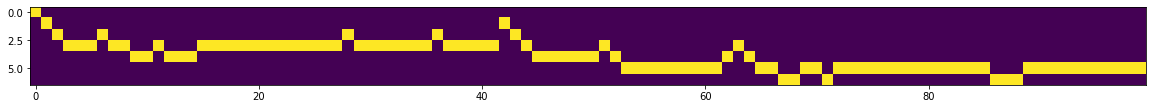

In [61]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(
    np.stack(list(tree_category.depth_map_array==i
                  for i in range(1,tree_category.depth_map_array.max()+1)))[:,:100])